# Integration Methods to Simulate Orbital Motions

The goal of this project was to examine the sensitivities of different integration algorithms for a $1/r^2$ force. 

Our general equations of motions were taken to be:

$\begin{align}
\frac{d\vec{v}}{dt} = -\frac{{\mu \; \vec{r}}}{|\vec{r}|^3} \\
\frac{d\vec{r}}{dt} = \vec{v}
\end{align}$

Where $\mu$ is some constant - think of this like normalizing $GM$ or $q^2 / m$.

$\vec{v}$ is the test particle velocity & $\vec{r}$ is the particle spatial coordinate. 
Since theses ODEs are coupled they have to integrated simultaneously in order to obtain a particle trajectory.

The trajectories were integrated in a right handed cartesian coordinate system 
A.K.A an (X,Y,Z)-space for those who want to talk like normal humans

The trajectories were integrated in the reference frame of the source particle such that $-\frac{{\mu}}{|\vec{r}|^2} \rightarrow \infty$ for $\vec{r} \rightarrow 0$ .

Numerically we defined $-\frac{{\mu }}{|r=0|^2}$ to throw an error in order to avoid singularities

## Defining the Vector Space and Acceleration Terms

Our first step was to define a simple function for getting the acceleration term for each vector coordinate.

This wasn't actually our first step but was done in hindsight after writing several functions. We realized that it was really helpful to make this helper function

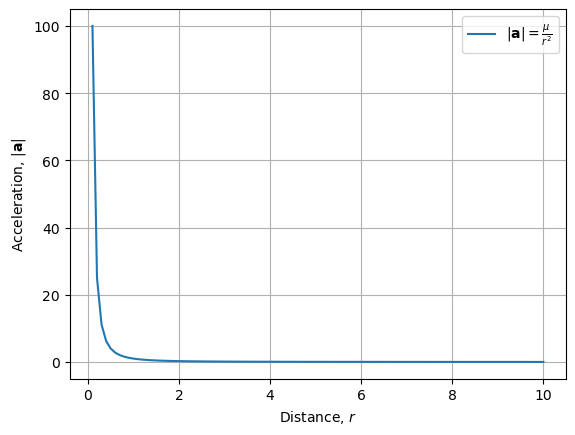

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def accel(x, mu=1.0):
    r2 = np.dot(x, x)
    r = np.sqrt(r2)
    #check for singularity
    if r == 0:
        raise ValueError("Singular position: r = 0")
    return -mu * x / (r2 * r)

r = np.linspace(0.1, 10.0, 100)

a = []  
for i in r:
    pos = np.array([i, 0.0, 0.0])
    avec = accel(pos)
    amag = np.linalg.norm(avec)
    a.append(amag)

a = np.array(a) # Convert list to a NumPy array

fig, ax = plt.subplots(1, 1)
ax.plot(r,a, label=r'$|\mathbf{a}| = \frac{\mu}{r^2}$')
ax.set_xlabel(r'Distance, $r$')
ax.set_ylabel(r'Acceleration, $|\mathbf{a}|$')
ax.grid(True)
ax.legend()
plt.show()



Notice that our acceleration function is vectorized. This was also something that took some time for us to realize was important. Originally we tried to integrate each component seperately.
Think $a_x = x \hat{x} / r^2$, but we realized we could make the code much more efficient this way. You can see how the original notation never changed - x is still the argument

Next we dug into the main goals of our project - actual integration!

We picked three (3) different algorithms for the integration: RK4, Leapfrog, and the Yoshida algorithm. 

## 4th Order Runge Kutta Method

We'll start by showing how we implemented the RK4 scheme. This was explained pretty in depth in class so we wont repeat it here. The basic scheme is as follows:

Given the vector phase 
$\begin{align}\vec{y}_n ​= \begin{bmatrix} \vec{r}_n \\ \vec{v}_n \end{bmatrix} \end{align}$ at time $t_n$​ 
the next step is calculated by:
$\begin{align} \vec{y}_{n+1​} = \vec{y}_n ​+ 6h​(k_{1}​+2k_{2}​+2k_{3}​+k_{4}​) \end{align}$

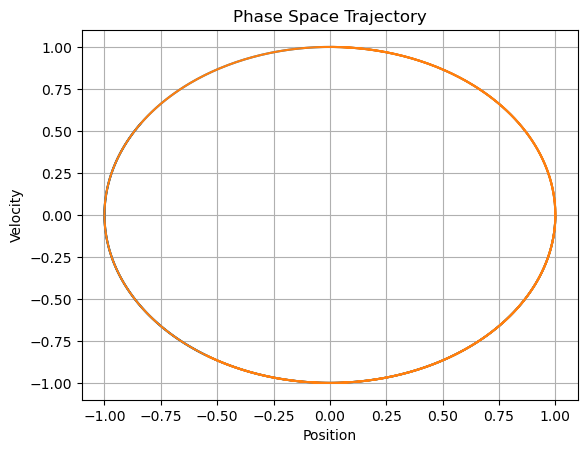

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def accel(x, mu=1.0):
    r2 = np.dot(x, x)
    r = np.sqrt(r2)
    #check for singularity
    if r == 0:
        raise ValueError("Singular position: r = 0")
    return -mu * x / (r2 * r)

def rk4_step(x, v, h, mu = 1.0):

    k1x = v
    k1v = accel(x)

    k2x = v + 0.5 * h * k1v
    k2v = accel(x + 0.5 * h * k1x)

    k3x = v + 0.5 * h * k2v
    k3v = accel(x + 0.5 * h * k2x)

    k4x = v + h * k3v
    k4v = accel(x + h * k3x)

    x_new = x + (h / 6.0) * (k1x + 2*k2x + 2*k3x + k4x)
    v_new = v + (h / 6.0) * (k1v + 2*k2v + 2*k3v + k4v)
    return x_new, v_new

mu = 1.0
h = 0.01
N = 1000
x0 = [1.0, 0.0, 0.0]
v0 = [0.0, 1.0, 0.0]

x = np.array(x0, dtype=float)
v = np.array(v0, dtype=float)

positions = []
velocities = []
for _ in range(N):
    x, v = rk4_step(x, v, h, mu)
    positions.append(x.copy())
    velocities.append(v.copy())

q = np.array(positions)
qdot = np.array(velocities)

fig, ax = plt.subplots(1, 1)
ax.plot(q,qdot)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Phase Space Trajectory')
ax.grid(True)

plt.show()

## Leapfrog Scheme

Next we did the Leapfrog Scheme

First Velocity Half-Step
$\begin{align} \vec{v}_{n+1/2} ​= \vec{v}_n ​+ \frac{1}{2} h \vec{​a}(\vec{r}_n​) \end{align}$

Position Update
$\begin{align} \vec{r}_{n+1} ​= \vec{r}_n ​+  h \vec{​v}_{n+1/2} \end{align}$

Next Velocity Half-Step:
$\begin{align} \vec{v}_{n+1} ​= \vec{v}_{n+1/2} ​+ \frac{1}{2} h \vec{​a}(\vec{r}_{n+1/2}​) \end{align}$

[[-0.00999975  0.99995     0.        ]
 [-0.0199985   0.99980001  0.        ]
 [-0.02999525  0.99955003  0.        ]
 ...
 [ 0.52681373 -0.84992636  0.        ]
 [ 0.53528612 -0.84461622  0.        ]
 [ 0.543705   -0.83922162  0.        ]]


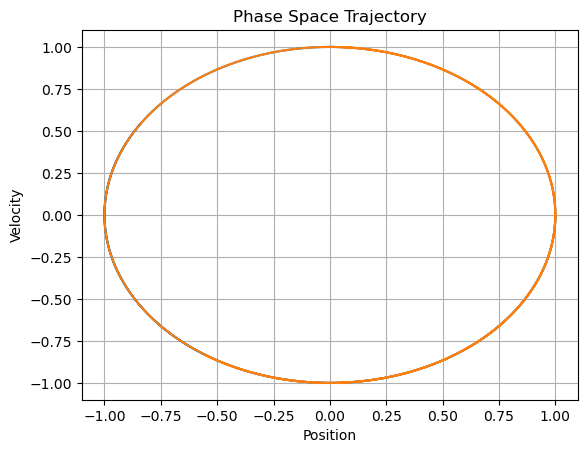

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def accel(x, mu=1.0):
    r2 = np.dot(x, x)
    r = np.sqrt(r2)
    #check for singularity
    if r == 0:
        raise ValueError("Singular position: r = 0")
    return -mu * x / (r2 * r)

def leapfrog_step(x, v, h, mu = 1.0):
    a = accel(x)
    v_half = v + 0.5 * h * a
    x_new = x + h * v_half
    a_new = accel(x_new)
    v_new = v_half + 0.5 * h * a_new
    return x_new, v_new

mu = 1.0
h = 0.01
N = 1000
x0 = [1.0, 0.0, 0.0]
v0 = [0.0, 1.0, 0.0]

x = np.array(x0, dtype=float)
v = np.array(v0, dtype=float)

positions = []
velocities = []
for _ in range(N):
    x, v = leapfrog_step(x, v, h, mu)
    positions.append(x.copy())
    velocities.append(v.copy())

q = np.array(positions)
qdot = np.array(velocities)
print(qdot)
fig, ax = plt.subplots(1, 1)
ax.plot(q,qdot)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Phase Space Trajectory')
ax.grid(True)
plt.show()

## Yoshida Algorithm

So we learned about this one from Wikipedia. We knew common algorithms for this type of problem - the RK4 scheme and the Leapfrog scheme. This is a new one to us - the 4 step Yoshida algorithm. It reminded us of RK4, and we learned it is derived from the leapfrog integrator. It has the same properties of the leapfrog in the sense that any energy drifts cancel out.

The Yoshida algorithm is the leapfrog integrator converted into a higher order integrator. The leapfrog integrator is essentially just applied over different timesteps. 

There are 2 sets of yoshida coefficients defined as $c_i$ and $d_i$. The c terms correspond to position updates and the d terms correspond to velocity updates. This is the part that is like the RK4 scheme, we're averaging over different tangent lines.


$\begin{align}
    w_0 \equiv -\frac{2^{1/3}}{2 - 2^{1/3}}, \\
    w_1 \equiv \frac{1}{2 - 2^{1/3}}, \\
    \\
    c_1 = c_4 = \frac{w_1}{2}, \\
    c_2 = c_3 = \frac{w_0 + w_1}{2}, \\
    d_1 = d_3 = w_1, \\
    d_2 = w_0 \\
    d_4 = 0
\end{align}$

Notice in the $d_i$ coefficients there are technically only 3 since $d_4 = 0$. This is where you can see the leapfrog technique come into play. One of the vectors is used as intermediary to get to the important step. 

$\begin{align}
  x_{i}^{1} = x_{i} + c_1 v_{i} h, \\
  v_{i}^{1} = v_{i} + d_1 a(x_{i}^{1}) h, \\
  \\
  x_{i}^{2} = x_{i}^{1} + c_2 v_{i}^{1} h, \\
  v_{i}^{2} = v_{i}^{1} + d_2 a(x_{i}^{2}) h, \\
  \\
  x_{i}^{3} = x_{i}^{2} + c_3 v_{i}^{2} h, \\
  v_{i}^{3} = v_{i}^{2} + d_3 a(x_{i}^{3}) h, \\
  \\
  x_{i+1} = x_{i}^{4} = x_{i}^{3} + c_4 v_{i}^{3} h, \\
  v_{i+1} = v_{i}^{4} = v_{i}^{3} + d_4 a(x_{i+1}) h
\end{align}$

[[-0.01000475  1.00027764  0.        ]
 [-0.02001834  1.00045548  0.        ]
 [-0.0300398   1.00053331  0.        ]
 ...
 [ 0.59109372 -0.78817601  0.        ]
 [ 0.59866643 -0.78209769  0.        ]
 [ 0.60617587 -0.77594967  0.        ]]


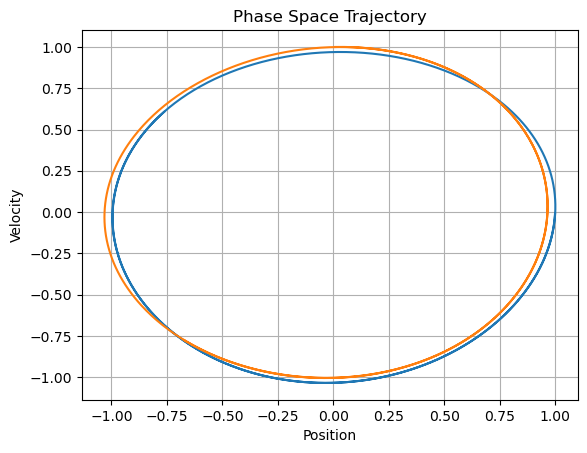

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def accel(x, mu=1.0):
    r2 = np.dot(x, x)
    r = np.sqrt(r2)
    #check for singularity
    if r == 0:
        raise ValueError("Singular position: r = 0")
    return -mu * x / (r2 * r)

def yoshida4_step(x, v, h, mu=1.0):

    w1 = 1.0 / (2.0 - 2.0**(1.0/3.0))
    w0 = - (2.0**(1.0/3.0)) / (2.0 - 2.0**(1.0/3.0))
    c = np.zeros(5)
    d = c
    c[0] = w1/2
    c[1] = (w0+w1)/2
    c[2] = (w0+w1)/2
    c[3] = w1/2
    d[0] = w1
    d[1] = w0
    d[2] = w1
    d[3] = 0.0

    for i in range(4):
        v = v + d[i] * h * accel(x)
        x = x + c[i] * h * v
    return x, v

mu = 1.0
h = 0.01
N = 1000
x0 = [1.0, 0.0, 0.0]
v0 = [0.0, 1.0, 0.0]

x = np.array(x0, dtype=float)
v = np.array(v0, dtype=float)

positions = []
velocities = []
for _ in range(N):
    x, v = yoshida4_step(x, v, h, mu)
    positions.append(x.copy())
    velocities.append(v.copy())

q = np.array(positions)
qdot = np.array(velocities)

print(qdot)
fig, ax = plt.subplots(1, 1)
ax.plot(q,qdot)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Phase Space Trajectory')
ax.grid(True)
plt.show()

Notice anything strange? In case you didn't realize, we've been plotting the vector coordinates over each other and there hasn't been any huge discrepancy until now. We see one of the vectors (x,vx) are now not in sync with the rest of the code. 

So we get phase space trajectories that all pass the eyeball test more or less. Next we want to compare these in a more quantitative way.

We picked 3 physical quantities to judge our algorithms: position, velocity, and energy. We also compared our results to Kepler's laws.

To do this we made a simple class to hold all our methods, which we'll show in just a bit. 



## Kepler's 2nd Law

As we all know so well by now, Kepler's 2nd law states that in an elliptical orbit, equal areas are covered in equal time - so the orbital radius and angular velocity of a planet will vary in its orbit. Expressed mathematically, we have

$\begin{align}
    \frac{dA}{dt} = \frac{1}{2}(\vec{r} \times \vec{v})
\end{align}$

Where an elliptical orbit is represented by

$\begin{align}
    r = \frac{p}{1 + \varepsilon \cos\theta}
\end{align}$

$\varepsilon$ is the eccentrcity of the orbit, and $\textit{p}$ can be related to the semimajor axis $\textit{a}$ by:

$\begin{align}
    p = a(1 - \varepsilon^{2})
\end{align}$

Combining, we have 
$\begin{align}
    r = \frac{a(1 - \varepsilon^{2})}{1 + \varepsilon \cos\theta}
\end{align}$

To maintain consistency in the coordinate plane, we let

$\begin{align}
    x = r \cos\theta \\
    y = r \sin\theta
\end{align}$

## Classes and Structure

In [22]:
import numpy as np
import matplotlib.pyplot as plt

class orbit_integrator:
    """
    Integrator for a particle moving in a central 1/r^2 potential.
    Supports leapfrog, RK4, and Yoshida 4th-order symplectic schemes.
    """

    def __init__(self, mu=1.0, h=0.01, method="leapfrog"):
        """
        Parameters
        ----------
        mu : float
            Gravitational parameter (G*M).
        h : float
            Time step size.
        method : str
            Integration method: 'leapfrog', 'rk4', or 'yoshida4'.
        """
        self.mu = mu
        self.h = h
        self.method = method.lower()
        if self.method not in ["leapfrog", "rk4", "yoshida4"]:
            raise ValueError("method must be 'leapfrog', 'rk4', or 'yoshida4'")

        # storage
        self.positions = []
        self.velocities = []
        self.energies = []

    # -------------------------
    # Core acceleration function
    # -------------------------
    def accel(self, x):
        r2 = np.dot(x, x)
        r = np.sqrt(r2)
        if r == 0:
            raise ValueError("Singular position: r = 0")
        return -self.mu * x / (r2 * r)

    # -------------------------
    # Integration methods
    # -------------------------
    def leapfrog_step(self, x, v):
        a = self.accel(x)
        v_half = v + 0.5 * self.h * a
        x_new = x + self.h * v_half
        a_new = self.accel(x_new)
        v_new = v_half + 0.5 * self.h * a_new
        return x_new, v_new

    def rk4_step(self, x, v):
        h = self.h
        mu = self.mu

        k1x = v
        k1v = self.accel(x)

        k2x = v + 0.5 * h * k1v
        k2v = self.accel(x + 0.5 * h * k1x)

        k3x = v + 0.5 * h * k2v
        k3v = self.accel(x + 0.5 * h * k2x)

        k4x = v + h * k3v
        k4v = self.accel(x + h * k3x)

        x_new = x + (h / 6.0) * (k1x + 2*k2x + 2*k3x + k4x)
        v_new = v + (h / 6.0) * (k1v + 2*k2v + 2*k3v + k4v)
        return x_new, v_new

    def yoshida4_step(self, x, v):
        h = self.h
        mu = self.mu

        w1 = 1.0 / (2.0 - 2.0**(1.0/3.0))
        w0 = - (2.0**(1.0/3.0)) / (2.0 - 2.0**(1.0/3.0))
        c = np.zeros(5)
        d = c
        c[0] = w1/2
        c[1] = (w0+w1)/2
        c[2] = (w0+w1)/2
        c[3] = w1/2
        d[0] = w1
        d[1] = w0
        d[2] = w1
        d[3] = 0.0

        for i in range(4):
            v = v + d[i] * h * self.accel(x)
            x = x + c[i] * h * v
        return x, v

    # -------------------------
    # Energy computation
    # -------------------------
    def energy(self, x, v):
        r = np.linalg.norm(x)
        return 0.5 * np.dot(v, v) - self.mu / r
    
    # -------------------------
    #Keplers 2nd law
    # -------------------------

    def area_velocity(self):
        pos = np.array(self.positions)
        vel = np.array(self.velocities)
        return 0.5 * np.abs(pos[:,0]*vel[:,1] - pos[:,1]*vel[:,0])

    def kepler_orbit(self, a, e, N):
        theta = np.linspace(0, 2*np.pi, N)
        r = a * (1 - e**2)/(1 + e * np.cos(theta))
        x = r * np.cos(theta)
        y = r * np.sin(theta)

        return x, y
    
    # -------------------------
    # Main integration routine
    # -------------------------
    def integrate(self, x0, v0, Nsteps):
        """
        Integrate for Nsteps starting from x0, v0.
        """
        x = np.array(x0, dtype=float)
        v = np.array(v0, dtype=float)

        self.positions = [x.copy()]
        self.velocities = [v.copy()]
        self.energies = [self.energy(x, v)]

        for _ in range(Nsteps):
            if self.method == "leapfrog":
                x, v = self.leapfrog_step(x, v)
            elif self.method == "rk4":
                x, v = self.rk4_step(x, v)
            elif self.method == "yoshida4":
                x, v = self.yoshida4_step(x, v)

            self.positions.append(x.copy())
            self.velocities.append(v.copy())
            self.energies.append(self.energy(x, v))

        self.positions = np.array(self.positions)
        self.velocities = np.array(self.velocities)
        self.energies = np.array(self.energies)
        return self.positions, self.velocities

    # -------------------------
    # Plotting helpers
    # -------------------------
    def plot_orbit(self, show_energy=False):
        pos = np.array(self.positions)
        plt.plot(pos[:,0], pos[:,1], label=self.method)
        plt.axis('equal')
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.title(f"Orbit using {self.method.upper()} Integrator")
        plt.show()

        if show_energy:
            plt.plot(self.energies)
            plt.xlabel("Step")
            plt.ylabel("Energy")
            plt.title(f"Energy Conservation: {self.method.upper()}")
            plt.show()

# if __name__ == "__main__":
#     mu = 1.0
#     h = 0.01
#     N = 10000
#     x0 = [1.0, 0.0, 0.0]
#     v0 = [0.0, 1.0, 0.0]

#     methods = ["leapfrog", "rk4", "yoshida4"]
#     for m in methods:
#         sim = orbit_integrator(mu=mu, h=h, method=m)
#         sim.integrate(x0, v0, N)
#         sim.plot_orbit(show_energy=True)

Just to prove the code isn't broken here are some test runs for different initial conditions

### Leapfrog, RK4, and Yoshida

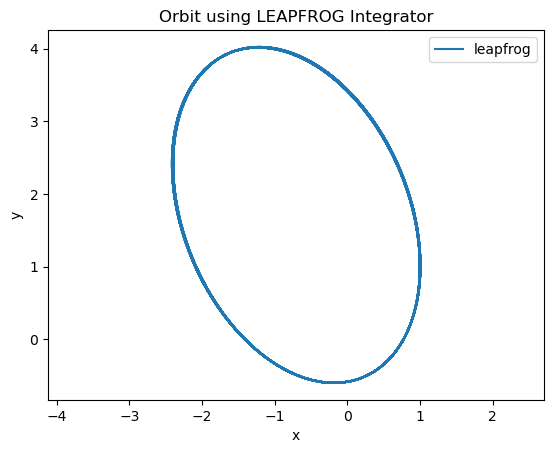

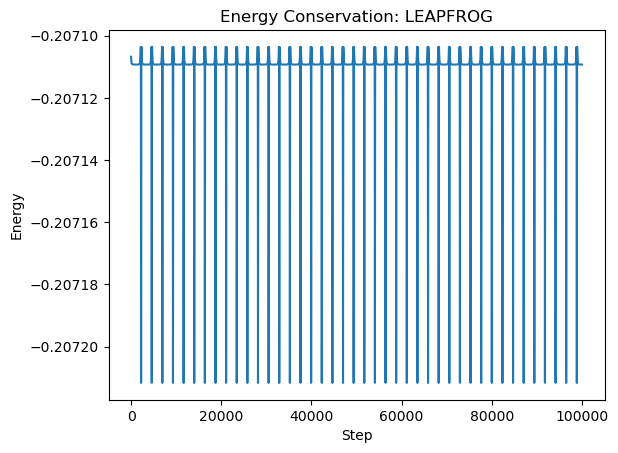

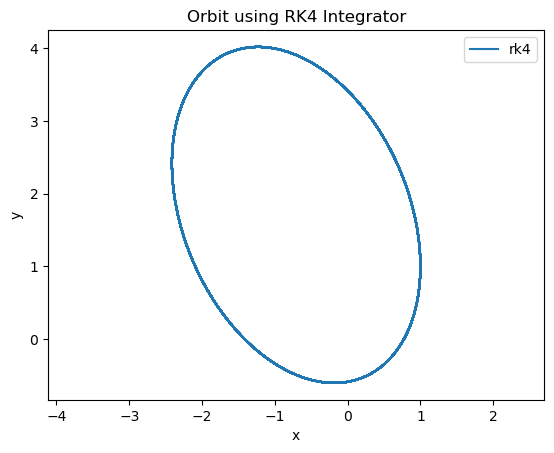

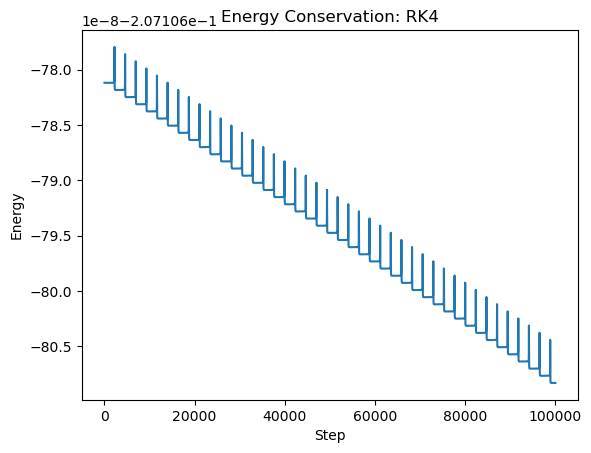

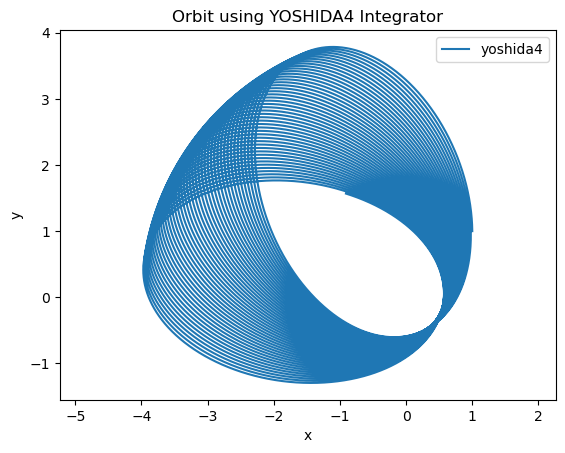

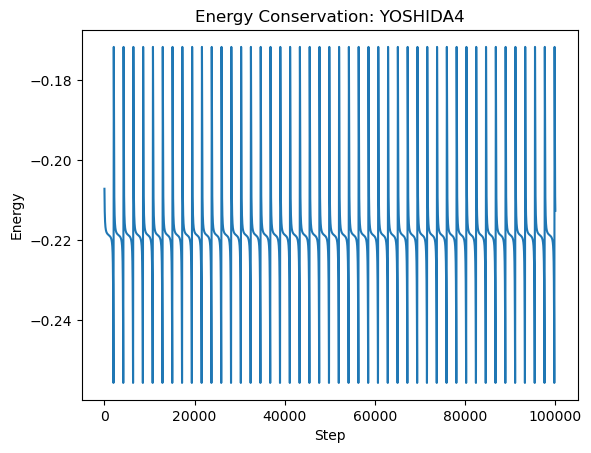

In [23]:
mu = 1.0
h = 0.01
N = 100000
x0 = [1.0, 1.0, 0.0]
v0 = [0.0, 1.0, 0.0]

methods = ["leapfrog", "rk4", "yoshida4"]
for m in methods:
    sim = orbit_integrator(mu=mu, h=h, method=m)
    sim.integrate(x0, v0, N)
    sim.plot_orbit(show_energy=True)

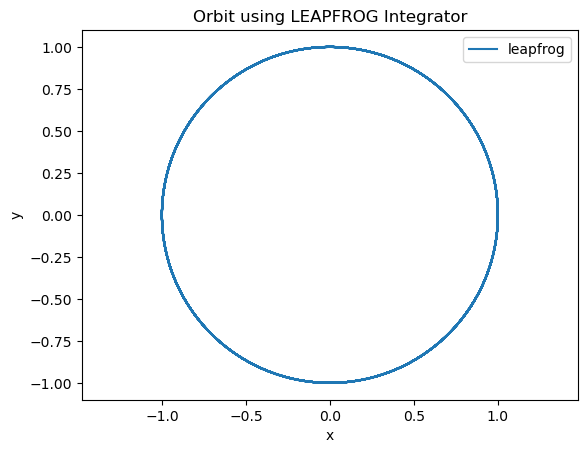

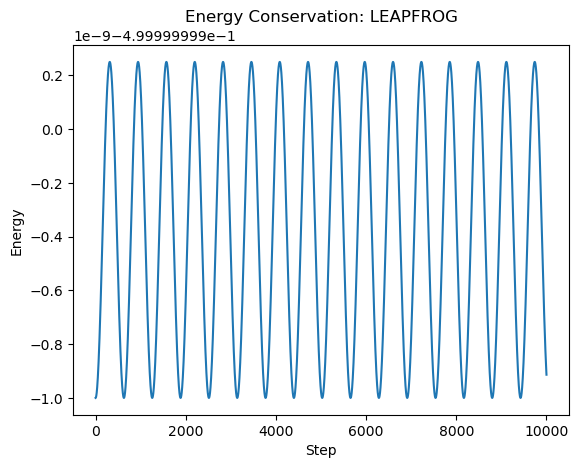

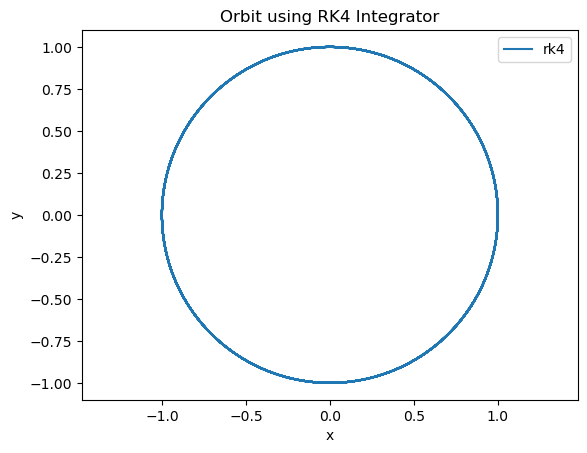

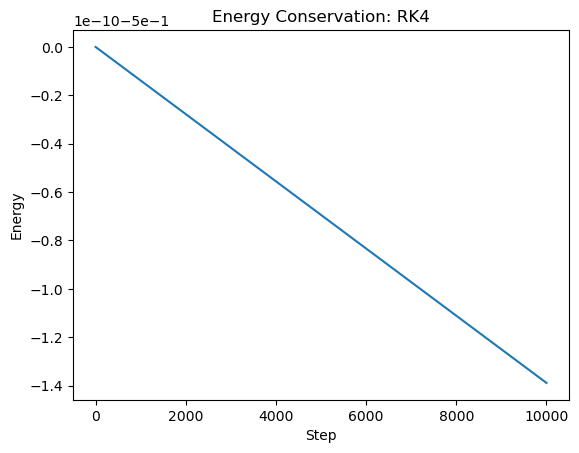

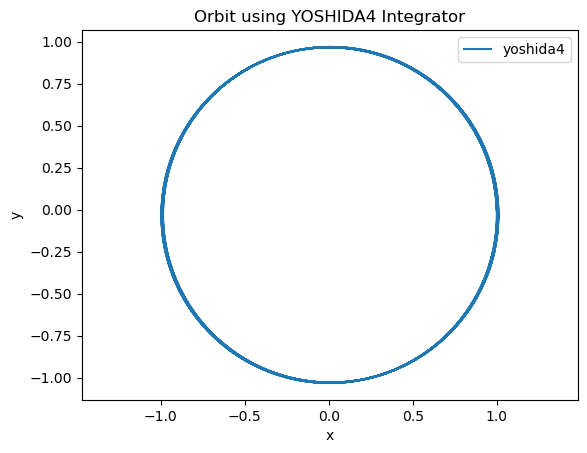

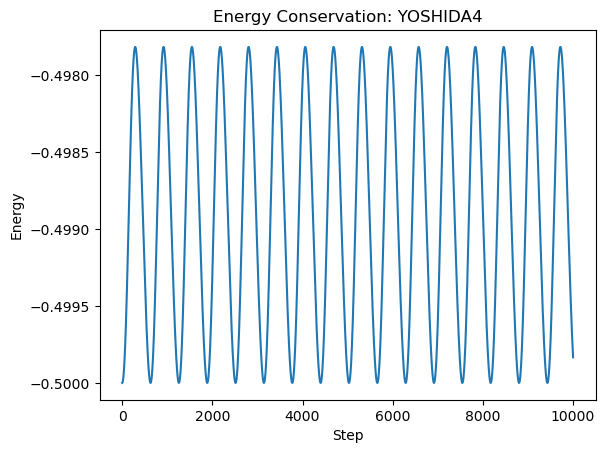

In [24]:
mu = 1.0
h = 0.01
N = 10000
x0 = [1.0, 0.0, 0.0]
v0 = [0.0, 1.0, 0.0]

methods = ["leapfrog", "rk4", "yoshida4"]
for m in methods:
    sim = orbit_integrator(mu=mu, h=h, method=m)
    sim.integrate(x0, v0, N)
    sim.plot_orbit(show_energy=True)

We can see the orbits nicely plotted along with the energy conservation (or lack thereof). We want to see a cyclical energy, the downward drift we see in the RK4 energy plot shows an energy loss - showing that it fails for this type of a problem

### Comparison to Kepler's Laws

Finally, let's see how these methods compare to Kepler's laws of motion. Here, we use the Mercury's orbital parameters, mainly because it's the planet with the highest eccentricity in our solar system. Let's pay special attention to the areal velocity - the rate at which the planet sweeps out an area as it moves along its orbit. 

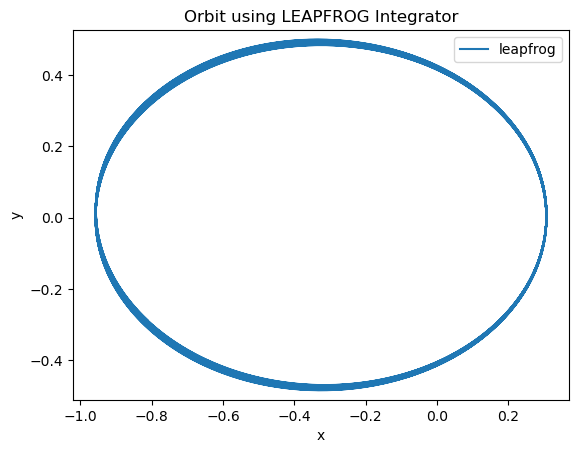

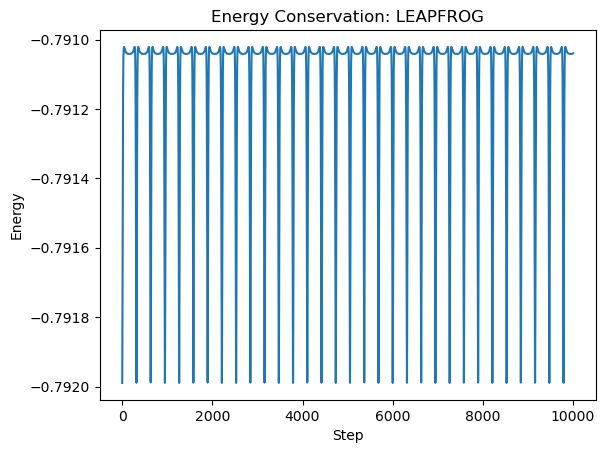

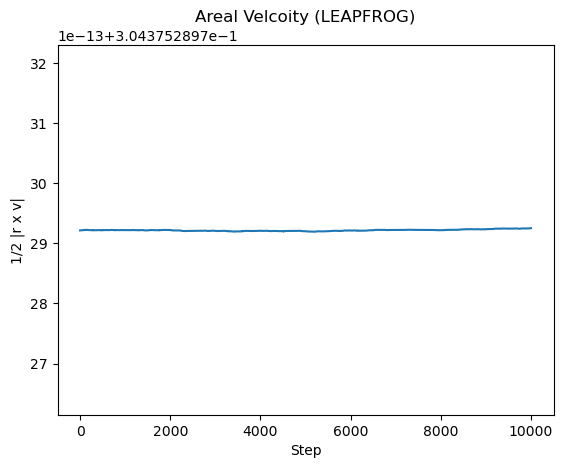

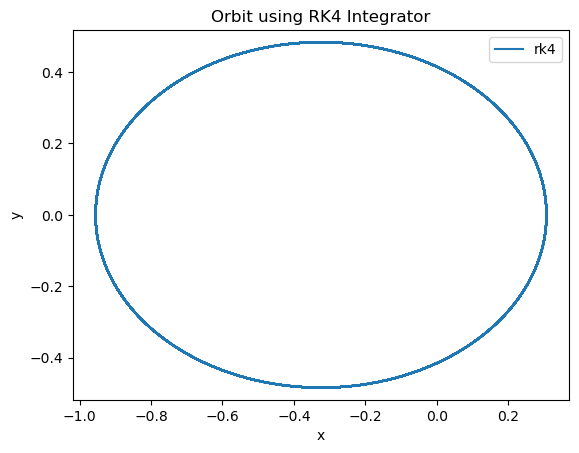

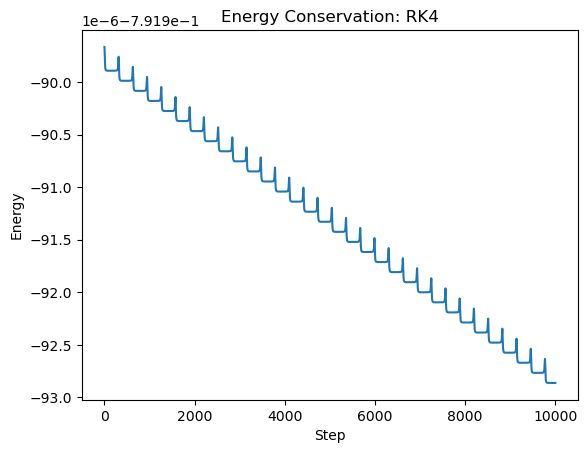

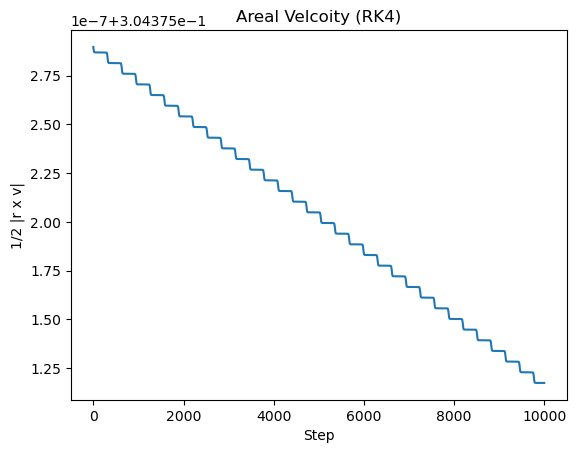

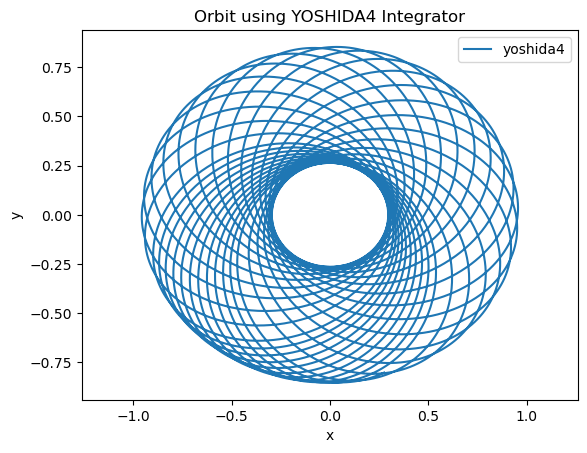

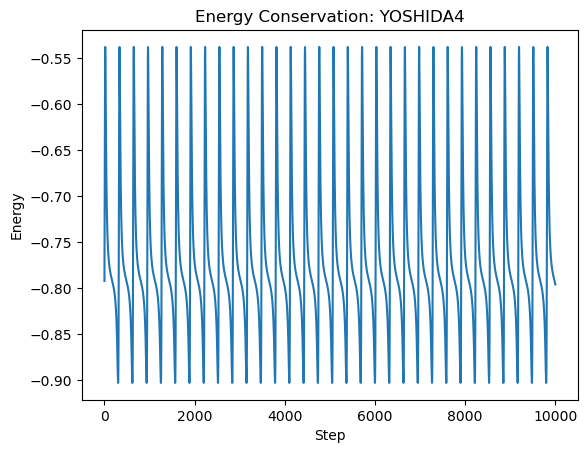

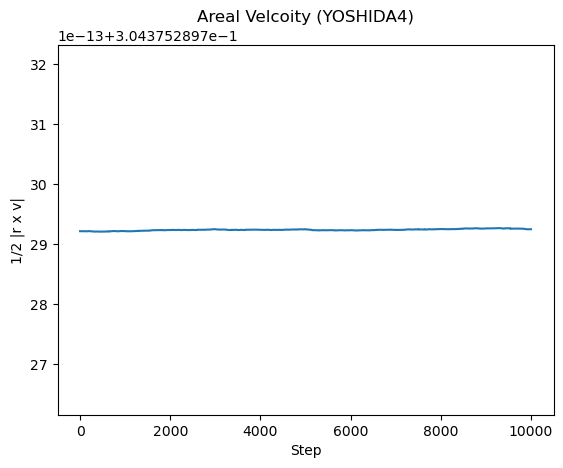

In [25]:
mu = 1.0
h = 0.01
N = 10000

#elliptical orbit parameters for mercury
a = 0.387 #semimajor axis in AU
e = 0.206 #eccentricity
r0 = a * (1 - e)
v0_mag = np.sqrt(mu * (1 + e)/ (a * (1 - e)))

x0 = [r0, 0.0, 0.0]
v0 = [0.0, v0_mag, 1.0]

methods = ["leapfrog", "rk4", "yoshida4"]
for m in methods:
    sim = orbit_integrator(mu=mu, h=h, method=m)
    sim.integrate(x0, v0, N)
    sim.plot_orbit(show_energy=True)

    #keplers 2nd law - areal velocity
    area_vel = sim.area_velocity()
    plt.plot(area_vel)
    plt.title(f"Areal Velcoity ({m.upper()})")
    plt.xlabel("Step")
    plt.ylabel("1/2 |r x v|")
    plt.show()


Alright, so what are we seeing here? The orbits show variability in movement - this is what we want! We can see the the Yoshida method actually completes orbits around its foci. For areal velocity, we want to see a straight, steady line. This shows that the area that's swept out remains constant over time. It makes sense that the Yoshida and Leapfrog methods are the two with the most even areal velocity lines, considering this is the algorithms intended target and it is derived from the Leapfrog algorithm. 
